In [7]:
"""
urllib.request:
用於處理 URL 開啟及讀取網路資料，例如從網頁下載檔案或取得 API 回應。

json:
用於處理 JSON 格式的資料，將 JSON 字串轉換成 Python 物件或反之。

sqlite3:
提供與 SQLite 資料庫互動的功能，例如建立資料庫、建立表格、新增資料、查詢資料等。

pandas:
強大的資料處理套件，提供 DataFrame 資料結構，用於資料整理、分析、操作等，例如讀取 CSV 檔案、資料清理、資料轉換。

matplotlib.pyplot:
用於繪製圖表，例如線圖、散佈圖、直方圖等，用於資料視覺化。

geopandas:
處理地理空間資料的套件，結合了 pandas 和 Shapely，用於地理資料分析、操作和繪製地圖。
"""
import urllib.request
import json
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

import geopandas as gpd

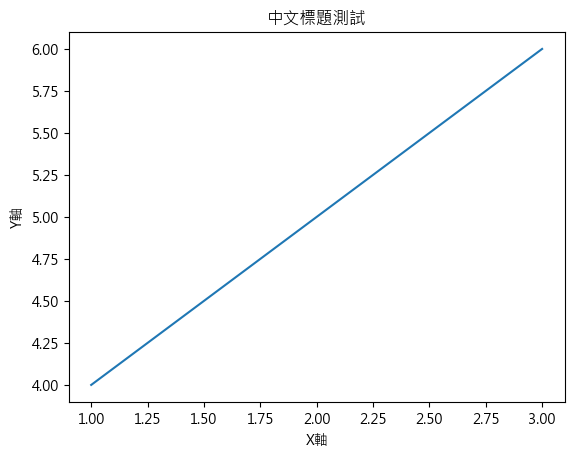

In [14]:
import matplotlib.pyplot as plt

# 使用 Microsoft JhengHei 或其他已安裝的中文字體
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']  # 微軟正黑體
plt.rcParams['axes.unicode_minus'] = False  # 解決負號顯示問題

# 繪製範例圖
plt.plot([1, 2, 3], [4, 5, 6])
plt.title('中文標題測試')
plt.xlabel('X軸')
plt.ylabel('Y軸')
plt.show()


In [15]:
# 讀取 Youbike 站點資訊
url = "https://tcgbusfs.blob.core.windows.net/dotapp/youbike/v2/youbike_immediate.json"

try:
    # 使用 urllib 直接讀取 JSON 數據
    with urllib.request.urlopen(url) as response:
        data = json.loads(response.read().decode())

    # 連接到 SQLite 數據庫（如果不存在則創建）
    conn = sqlite3.connect('youbike_data.db')
    cursor = conn.cursor()

    # 創建表（如果不存在）
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS youbike_stations (
        sno TEXT PRIMARY KEY,
        sna TEXT,
        sarea TEXT,
        mday TEXT,
        ar TEXT,
        sareaen TEXT,
        snaen TEXT,
        aren TEXT,
        act TEXT,
        srcUpdateTime TEXT,
        updateTime TEXT,
        infoTime TEXT,
        infoDate TEXT,
        total INTEGER,
        available_rent_bikes INTEGER,
        latitude REAL,
        longitude REAL,
        available_return_bikes INTEGER
    )
    ''')

    # 準備插入數據的 SQL 語句
    insert_sql = '''
    INSERT OR REPLACE INTO youbike_stations (
        sno, sna, sarea, mday, ar, sareaen, snaen, aren, act,
        srcUpdateTime, updateTime, infoTime, infoDate, total,
        available_rent_bikes, latitude, longitude, available_return_bikes
    )
    VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
    '''

    # 遍歷數據並插入到數據庫
    for station in data:
        cursor.execute(insert_sql, (
            station["sno"],
            station["sna"],
            station["sarea"],
            station["mday"],
            station["ar"],
            station["sareaen"],
            station["snaen"],
            station["aren"],
            station["act"],
            station["srcUpdateTime"],
            station["updateTime"],
            station["infoTime"],
            station["infoDate"],
            int(station["total"]),
            int(station["available_rent_bikes"]),
            float(station["latitude"]),
            float(station["longitude"]),
            int(station["available_return_bikes"])
        ))

    # 提交更改並關閉連接
    conn.commit()
    conn.close()

    print("數據已成功插入到 SQLite 數據庫中。")

    # 顯示插入的數據數量和部分示例
    conn = sqlite3.connect('youbike_data.db')
    cursor = conn.cursor()

    cursor.execute("SELECT COUNT(*) FROM youbike_stations")
    count = cursor.fetchone()[0]
    print(f"當前數據庫中共有 {count} 條記錄。")

    print("\n示例數據（前3條記錄）：")
    cursor.execute("""
    SELECT sno, sna, sarea, total, available_rent_bikes, available_return_bikes, mday
    FROM youbike_stations LIMIT 3
    """)
    rows = cursor.fetchall()
    for row in rows:
        print(row)

    conn.close()

except urllib.error.URLError as e:
    print(f"無法連接到 URL: {e}")
except json.JSONDecodeError as e:
    print(f"JSON 解碼錯誤: {e}")
except sqlite3.Error as e:
    print(f"SQLite 錯誤: {e}")
except Exception as e:
    print(f"發生未預期的錯誤: {e}")

數據已成功插入到 SQLite 數據庫中。
當前數據庫中共有 1480 條記錄。

示例數據（前3條記錄）：
('500101001', 'YouBike2.0_捷運科技大樓站', '大安區', 28, 11, 17, '2024-10-23 15:16:19')
('500101002', 'YouBike2.0_復興南路二段273號前', '大安區', 21, 2, 19, '2024-10-23 15:10:19')
('500101003', 'YouBike2.0_國北教大實小東側門', '大安區', 16, 1, 15, '2024-10-23 15:10:19')


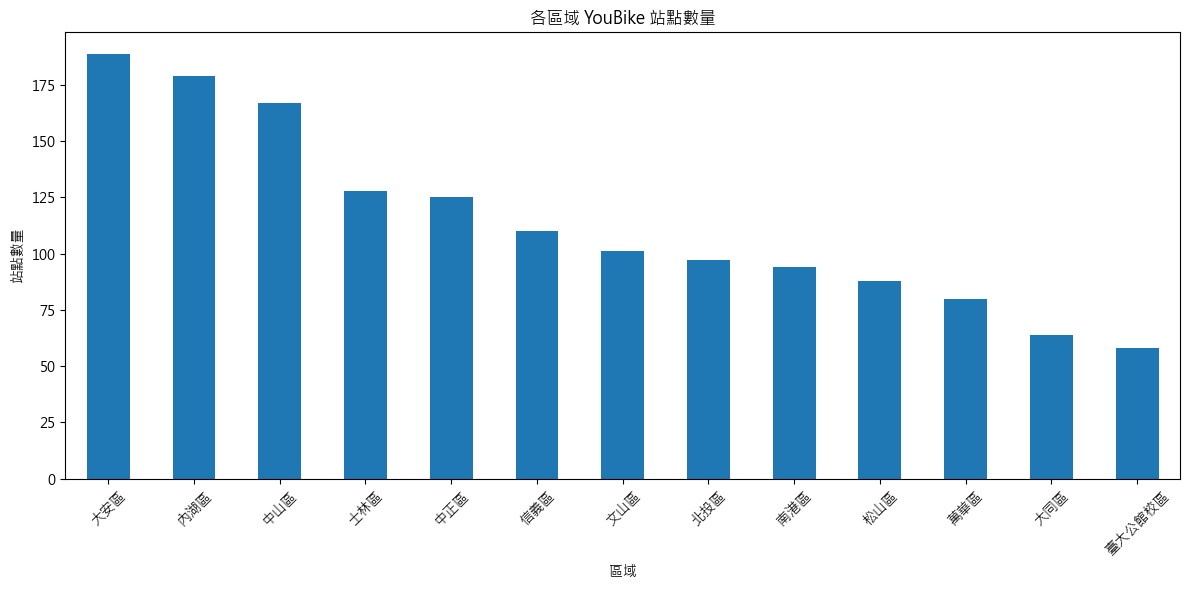

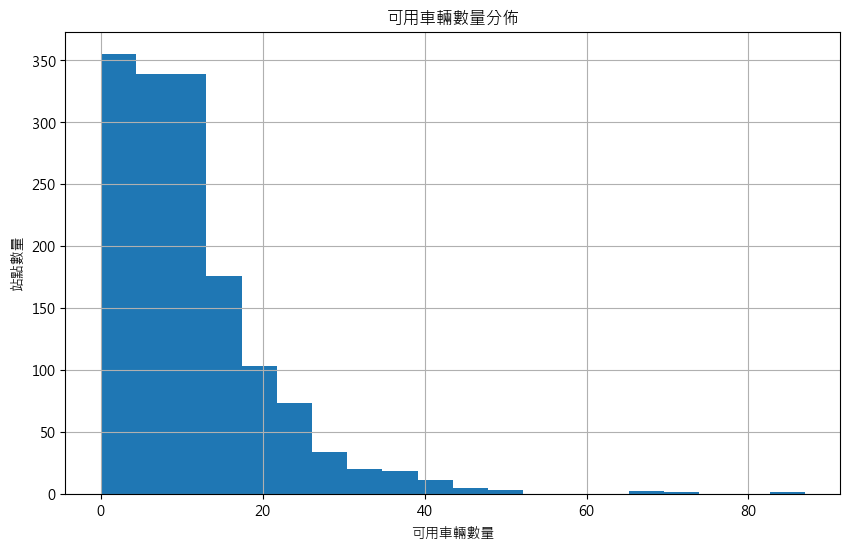

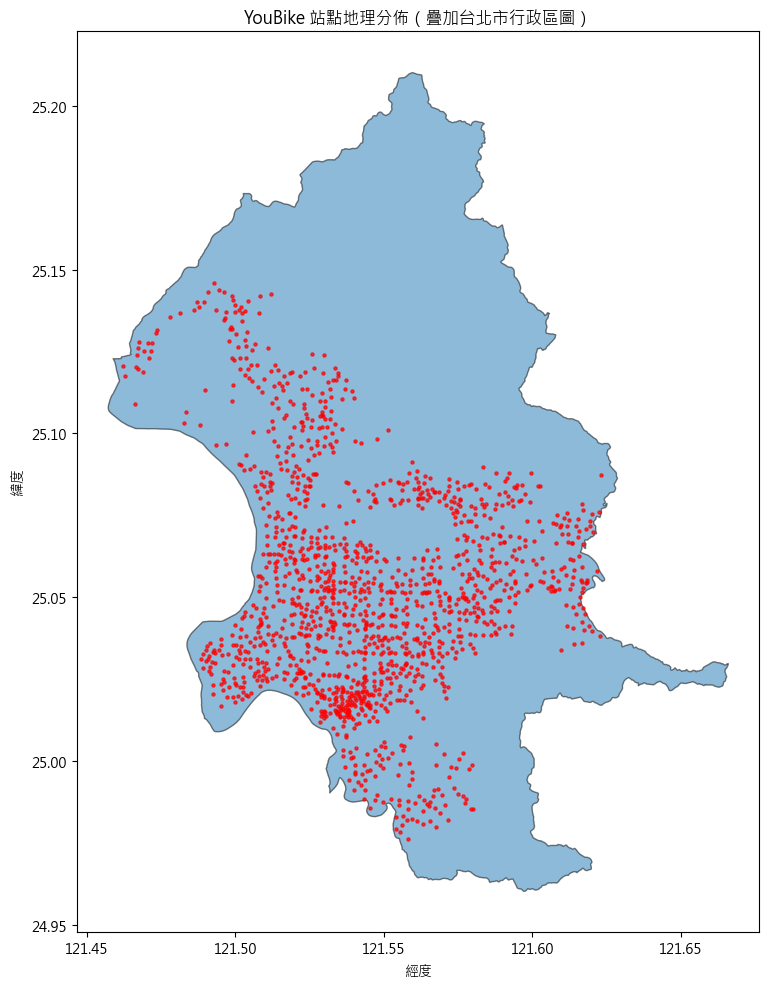

數據分析圖表已生成。


In [16]:
# 數據分析和可視化部分
try:
    # 讀取數據
    conn = sqlite3.connect('youbike_data.db')
    df = pd.read_sql_query("SELECT * FROM youbike_stations", conn)
    conn.close()

    # 1. 各區域的站點數量統計
    area_counts = df['sarea'].value_counts()
    plt.figure(figsize=(12, 6))
    area_counts.plot(kind='bar')
    plt.title('各區域 YouBike 站點數量')
    plt.xlabel('區域')
    plt.ylabel('站點數量')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # 2. 可用車輛數量的分佈情況
    plt.figure(figsize=(10, 6))
    df['available_rent_bikes'].hist(bins=20)
    plt.title('可用車輛數量分佈')
    plt.xlabel('可用車輛數量')
    plt.ylabel('站點數量')
    plt.show()

    # 3. 站點位置的地理分佈（加上台北市行政區圖）
    # 讀取台北市行政區域地圖
    # 注意：您需要下載台北市的 GeoJSON 文件並放在正確的路徑下
    taipei_map = gpd.read_file('geojson_Taipei.json')

    # 創建 GeoDataFrame
    gdf = gpd.GeoDataFrame(
        df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs="EPSG:4326"
    )

    # 繪圖
    fig, ax = plt.subplots(figsize=(15, 10))

    # 繪製台北市行政區域
    taipei_map.plot(ax=ax, alpha=0.5, edgecolor='k')

    # 繪製站點
    gdf.plot(ax=ax, color='red', markersize=5, alpha=0.7)

    plt.title('YouBike 站點地理分佈（疊加台北市行政區圖）')
    plt.xlabel('經度')
    plt.ylabel('緯度')
    plt.tight_layout()
    plt.show()

    print("數據分析圖表已生成。")

except Exception as e:
    print(f"在數據分析和可視化過程中發生錯誤: {e}")

In [6]:
# 將資料轉換為DataFrame
df = pd.DataFrame(data)
# 顯示 DataFrame 的前幾行
df.head()

,sno,sna,sarea,mday,ar,sareaen,snaen,aren,act,srcUpdateTime,updateTime,infoTime,infoDate,total,available_rent_bikes,latitude,longitude,available_return_bikes
0,500101001,YouBike2.0_捷運科技大樓站,大安區,2024-09-30 23:56:19,復興南路二段235號前,Daan Dist.,YouBike2.0_MRT Technology Bldg. Sta.,No.235， Sec. 2， Fuxing S. Rd.,1,2024-09-30 23:58:22,2024-09-30 23:58:26,2024-09-30 23:56:19,2024-09-30,28,24,25.02605,121.54360,3
1,500101002,YouBike2.0_復興南路二段273號前,大安區,2024-09-30 23:53:16,復興南路二段273號西側,Daan Dist.,YouBike2.0_No.273， Sec. 2， Fuxing S. Rd.,No.273， Sec. 2， Fuxing S. Rd. (West),1,2024-09-30 23:58:22,2024-09-30 23:58:26,2024-09-30 23:53:16,2024-09-30,21,20,25.02565,121.54357,1
2,500101003,YouBike2.0_國北教大實小東側門,大安區,2024-09-30 23:38:17,和平東路二段96巷7號,Daan Dist.,YouBike2.0_NTUE Experiment Elementary School (...,No. 7， Ln. 96， Sec. 2， Heping E. Rd,1,2024-09-30 23:58:22,2024-09-30 23:58:26,2024-09-30 23:38:17,2024-09-30,16,8,25.02429,121.54124,8
3,500101004,YouBike2.0_和平公園東側,大安區,2024-09-30 23:47:15,和平東路二段118巷33號,Daan Dist.,YouBike2.0_Heping Park (East),No. 33， Ln. 118， Sec. 2， Heping E. Rd,1,2024-09-30 23:58:22,2024-09-30 23:58:26,2024-09-30 23:47:15,2024-09-30,11,11,25.02351,121.54282,0
4,500101005,YouBike2.0_辛亥復興路口西北側,大安區,2024-09-30 23:42:16,復興南路二段368號,Daan Dist.,YouBike2.0_Xinhai Fuxing Rd. Intersection (Nor...,No. 368， Sec. 2， Fuxing S. Rd.,1,2024-09-30 23:58:22,2024-09-30 23:58:26,2024-09-30 23:42:16,2024-09-30,16,4,25.02153,121.54299,11


## 從基本的資料視覺化逐步過渡到簡單的預測模型

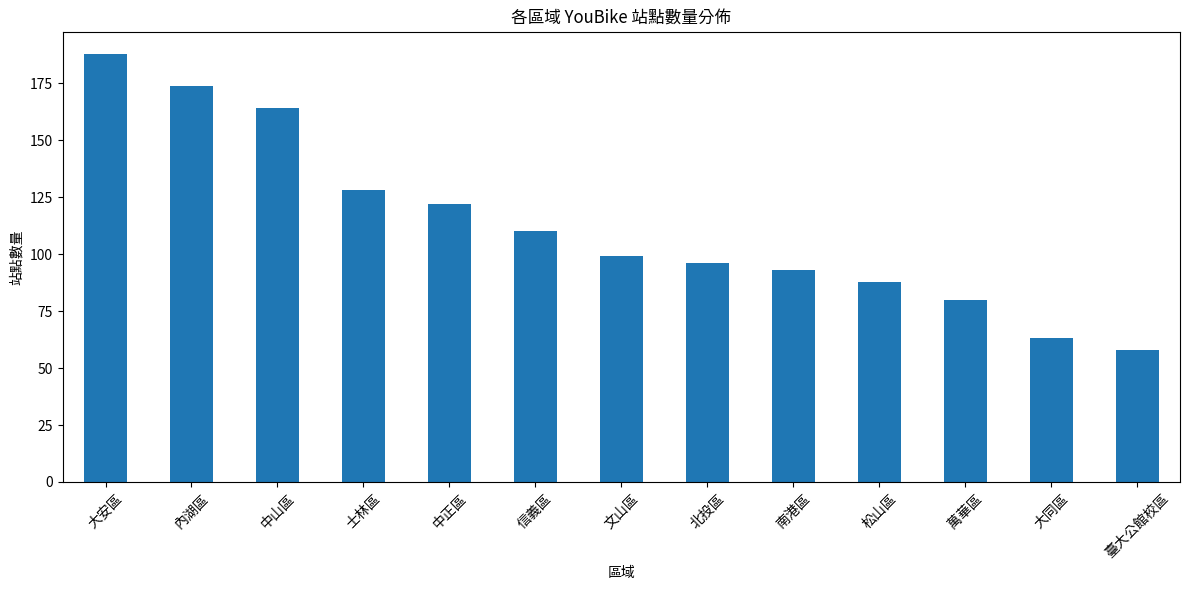

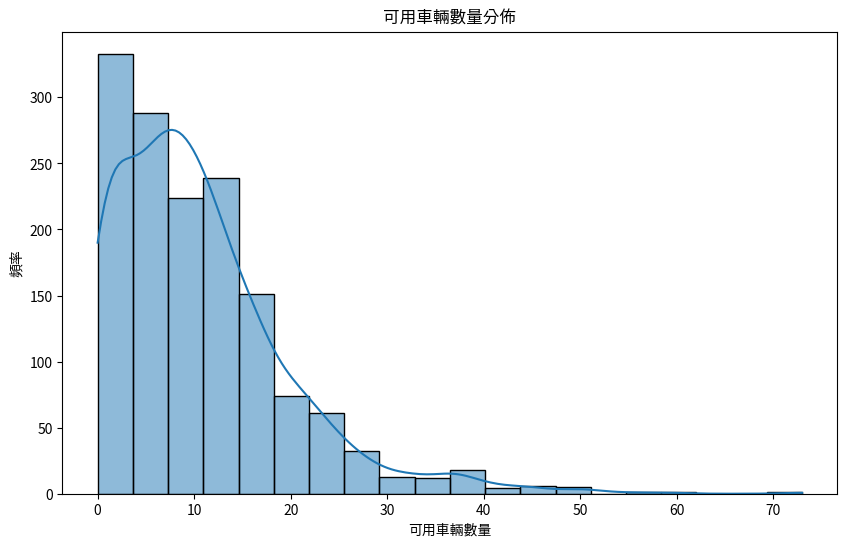

地圖已保存為 youbike_stations_map.html
沒有足夠的數據進行時間序列分析
沒有足夠的數據進行預測


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
import sqlite3
from datetime import datetime
import numpy as np

# 1. 數據載入和預處理
def load_data():
    try:
        conn = sqlite3.connect('youbike_data.db')
        df = pd.read_sql_query("SELECT * FROM youbike_stations", conn)
        conn.close()

        # 將mday轉換為日期時間格式
        df['mday'] = pd.to_datetime(df['mday'])

        # 按站點和時間排序
        df = df.sort_values(['sno', 'mday'])

        return df
    except Exception as e:
        print(f"數據載入錯誤: {e}")
        return None

df = load_data()
if df is None:
    print("無法繼續分析，請檢查數據庫連接和數據完整性。")
    exit()

# 2. 基本數據視覺化
def plot_station_distribution():
    try:
        plt.figure(figsize=(12, 6))
        df['sarea'].value_counts().plot(kind='bar')
        plt.title('各區域 YouBike 站點數量分佈')
        plt.xlabel('區域')
        plt.ylabel('站點數量')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"繪製站點分佈圖錯誤: {e}")

def plot_available_bikes_histogram():
    try:
        plt.figure(figsize=(10, 6))
        sns.histplot(df['available_rent_bikes'], bins=20, kde=True)
        plt.title('可用車輛數量分佈')
        plt.xlabel('可用車輛數量')
        plt.ylabel('頻率')
        plt.show()
    except Exception as e:
        print(f"繪製可用車輛直方圖錯誤: {e}")

# 3. 地理分佈視覺化
def plot_geographic_distribution():
    try:
        import folium

        # 計算台北市的中心點
        center_lat = df['latitude'].mean()
        center_lon = df['longitude'].mean()

        # 創建地圖
        m = folium.Map(location=[center_lat, center_lon], zoom_start=12)

        # 添加站點標記
        for idx, row in df.iterrows():
            folium.CircleMarker(
                location=[row['latitude'], row['longitude']],
                radius=5,
                popup=f"{row['sna']} - 可用車輛: {row['available_rent_bikes']}",
                color='red',
                fill=True,
                fillColor='red'
            ).add_to(m)

        # 保存地圖為HTML文件
        m.save("youbike_stations_map.html")
        print("地圖已保存為 youbike_stations_map.html")
    except Exception as e:
        print(f"生成地理分佈圖錯誤: {e}")

# 4. 時間序列分析
def plot_time_series():
    try:
        # 選擇一個特定站點進行分析
        station_data = df.groupby('sno').filter(lambda x: len(x) > 1).groupby('sno').first()
        if len(station_data) == 0:
            print("沒有足夠的數據進行時間序列分析")
            return

        station_sno = station_data.index[0]
        station_data = df[df['sno'] == station_sno]

        plt.figure(figsize=(12, 6))
        plt.plot(station_data['mday'], station_data['available_rent_bikes'])
        plt.title(f"站點 {station_data['sna'].iloc[0]} 可用車輛數量隨時間變化")
        plt.xlabel('時間')
        plt.ylabel('可用車輛數量')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"繪製時間序列圖錯誤: {e}")

# 5. 簡單預測模型
def simple_prediction_model():
    try:
        # 選擇一個有足夠數據的站點進行預測
        station_data = df.groupby('sno').filter(lambda x: len(x) > 2).groupby('sno').first()
        if len(station_data) == 0:
            print("沒有足夠的數據進行預測")
            return

        station_sno = station_data.index[0]
        station_data = df[df['sno'] == station_sno].copy()

        # 確保數據按時間排序
        station_data = station_data.sort_values('mday')

        # 準備數據
        station_data['ds'] = station_data['mday']
        station_data['y'] = station_data['available_rent_bikes']

        # 移除任何重複的時間戳
        station_data = station_data.drop_duplicates('ds')

        # 確保至少有兩個非NaN的數據點
        if station_data['y'].notna().sum() < 2:
            print(f"站點 {station_sno} 沒有足夠的非NaN數據點進行預測")
            return

        # 創建和訓練模型
        model = Prophet()
        model.fit(station_data[['ds', 'y']])

        # 生成未來48小時的預測
        future = model.make_future_dataframe(periods=48, freq='H')
        forecast = model.predict(future)

        # 繪製預測結果
        fig = model.plot(forecast)
        plt.title(f"站點 {station_data['sna'].iloc[0]} 未來48小時可用車輛數量預測")
        plt.xlabel('時間')
        plt.ylabel('預測的可用車輛數量')
        plt.show()
    except Exception as e:
        print(f"預測模型錯誤: {e}")

# 運行分析
plot_station_distribution()
plot_available_bikes_histogram()
plot_geographic_distribution()
plot_time_series()
simple_prediction_model()

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import folium
from folium.plugins import MarkerCluster, HeatMap
import numpy as np

# 1. 數據載入和預處理
def load_and_preprocess_data():
    try:
        conn = sqlite3.connect('youbike_data.db')
        df = pd.read_sql_query("SELECT * FROM youbike_stations", conn)
        conn.close()

        # 計算使用率
        df['usage_rate'] = df['available_rent_bikes'] / df['total']

        # 將經緯度轉換為數值型
        df['latitude'] = pd.to_numeric(df['latitude'], errors='coerce')
        df['longitude'] = pd.to_numeric(df['longitude'], errors='coerce')

        return df
    except Exception as e:
        print(f"數據載入錯誤: {e}")
        return None

df = load_and_preprocess_data()
if df is None:
    print("無法繼續分析，請檢查數據庫連接和數據完整性。")
    exit()

# 2. 改進的區域分析
def improved_area_analysis():
    try:
        # 計算每個區域的統計數據
        area_stats = df.groupby('sarea').agg({
            'sno': 'count',
            'available_rent_bikes': 'mean',
            'usage_rate': 'mean',
            'total': 'sum'
        }).sort_values('sno', ascending=False)

        area_stats.columns = ['站點數', '平均可用車輛', '平均使用率', '總車位數']

        # 創建子圖
        fig, axes = plt.subplots(2, 2, figsize=(20, 16))

        # 1. 站點數量
        area_stats['站點數'].plot(kind='bar', ax=axes[0, 0], color='skyblue')
        axes[0, 0].set_title('各區域站點數量')
        axes[0, 0].set_ylabel('站點數量')

        # 2. 平均可用車輛
        area_stats['平均可用車輛'].plot(kind='bar', ax=axes[0, 1], color='lightgreen')
        axes[0, 1].set_title('各區域平均可用車輛數量')
        axes[0, 1].set_ylabel('平均可用車輛數')

        # 3. 平均使用率
        area_stats['平均使用率'].plot(kind='bar', ax=axes[1, 0], color='salmon')
        axes[1, 0].set_title('各區域平均使用率')
        axes[1, 0].set_ylabel('平均使用率')

        # 4. 總車位數
        area_stats['總車位數'].plot(kind='bar', ax=axes[1, 1], color='purple')
        axes[1, 1].set_title('各區域總車位數')
        axes[1, 1].set_ylabel('總車位數')

        for ax in axes.flatten():
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

        plt.tight_layout()
        plt.savefig('area_analysis.png')
        plt.close()

        print("區域分析圖表已保存為 area_analysis.png")
    except Exception as e:
        print(f"改進的區域分析錯誤: {e}")

# 3. 使用率分析
def usage_rate_analysis():
    try:
        plt.figure(figsize=(12, 6))
        sns.histplot(df['usage_rate'], bins=30, kde=True)
        plt.title('站點使用率分佈')
        plt.xlabel('使用率')
        plt.ylabel('站點數量')
        plt.axvline(df['usage_rate'].mean(), color='r', linestyle='--', label='平均使用率')
        plt.legend()
        plt.savefig('usage_rate_distribution.png')
        plt.close()

        print("使用率分佈圖已保存為 usage_rate_distribution.png")

        # 找出使用率最高和最低的站點
        top_stations = df.nlargest(10, 'usage_rate')[['sna', 'usage_rate', 'available_rent_bikes', 'total']]
        bottom_stations = df.nsmallest(10, 'usage_rate')[['sna', 'usage_rate', 'available_rent_bikes', 'total']]

        print("\n使用率最高的10個站點：")
        print(top_stations.to_string(index=False))

        print("\n使用率最低的10個站點：")
        print(bottom_stations.to_string(index=False))
    except Exception as e:
        print(f"使用率分析錯誤: {e}")

# 4. 改進的地理分佈視覺化
def improved_geographic_distribution():
    try:
        # 計算台北市的中心點
        center_lat = df['latitude'].mean()
        center_lon = df['longitude'].mean()

        # 創建地圖
        m = folium.Map(location=[center_lat, center_lon], zoom_start=12)

        # 添加站點標記
        marker_cluster = MarkerCluster().add_to(m)
        for idx, row in df.iterrows():
            folium.CircleMarker(
                location=[row['latitude'], row['longitude']],
                radius=5,
                popup=f"{row['sna']}<br>可用車輛: {row['available_rent_bikes']}<br>使用率: {row['usage_rate']:.2f}",
                color='red',
                fill=True,
                fillColor='red'
            ).add_to(marker_cluster)

        # 添加熱力圖
        heat_data = [[row['latitude'], row['longitude'], row['usage_rate']] for idx, row in df.iterrows()]
        HeatMap(heat_data).add_to(m)

        # 保存地圖為HTML文件
        m.save("youbike_stations_map.html")
        print("改進的地理分佈圖已保存為 youbike_stations_map.html")
    except Exception as e:
        print(f"改進的地理分佈圖生成錯誤: {e}")

# 5. 相關性分析
def correlation_analysis():
    try:
        # 選擇數值型列進行相關性分析
        numeric_cols = ['available_rent_bikes', 'available_return_bikes', 'total', 'usage_rate']
        corr_matrix = df[numeric_cols].corr()

        plt.figure(figsize=(10, 8))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
        plt.title('數值特徵相關性熱圖')
        plt.tight_layout()
        plt.savefig('correlation_heatmap.png')
        plt.close()

        print("相關性熱圖已保存為 correlation_heatmap.png")
    except Exception as e:
        print(f"相關性分析錯誤: {e}")

# 6. 站點容量與使用率關係分析
def capacity_usage_analysis():
    try:
        plt.figure(figsize=(12, 8))
        sns.scatterplot(x='total', y='usage_rate', data=df, alpha=0.6)
        plt.title('站點總容量與使用率關係')
        plt.xlabel('站點總容量')
        plt.ylabel('使用率')
        plt.savefig('capacity_usage_relationship.png')
        plt.close()

        print("站點容量與使用率關係圖已保存為 capacity_usage_relationship.png")
    except Exception as e:
        print(f"站點容量與使用率關係分析錯誤: {e}")

# 運行分析
improved_area_analysis()
usage_rate_analysis()
improved_geographic_distribution()
correlation_analysis()
capacity_usage_analysis()

print("分析完成，請查看生成的圖表和HTML文件。")

區域分析圖表已保存為 area_analysis.png
使用率分佈圖已保存為 usage_rate_distribution.png

使用率最高的10個站點：
                     sna  usage_rate  available_rent_bikes  total
       YouBike2.0_和平公園東側         1.0                    11     11
    YouBike2.0_辛亥路一段30號前         1.0                     8      8
    YouBike2.0_和平復興路口西北側         1.0                     9      9
         YouBike2.0_溫州公園         1.0                     5      5
    YouBike2.0_臺大國青大樓宿舍前         1.0                    20     20
     YouBike2.0_基隆長興路口東側         1.0                    15     15
         YouBike2.0_芳和國中         1.0                    37     37
YouBike2.0_捷運臺電大樓站(2號出口)         1.0                    18     18
       YouBike2.0_和平泰順街口         1.0                     9      9
  YouBike2.0_復興南路二段128巷口         1.0                    37     37

使用率最低的10個站點：
                     sna  usage_rate  available_rent_bikes  total
   YouBike2.0_新生南路三段82號前         0.0                     0     20
        YouBike2.0_溫州停車場         0.0          